### Final project  
### Wind predictor "WeDOON"  
### For wind farms and single generator  


  
    
  
для решения необходимо задать  
широту, долготу и альтитуду  
места установки ветрогенератора

  
*направление ветра - откуда дует, т.е. ветер 180 градусв, означает - дует с юга

In [1]:
# uncomment for manual entry

# lat_test = float(input('enter lattitude ')) # in format xx.xxxx (deg)
# lon_test = float(input('enter longitude ')) # in format xx.xxxx (deg)
# alt_test = int(input('enter altitude ')) # in format xx (m)


в учебных целях используются координаты м.Таран в Калининградской области,  
не затенено поверхностью порядка 300 градусов,  
место открыто для всех преобладающих ветров в данном регионе  

In [2]:
lat_test = 54.9591
lon_test = 19.978
alt_test = 30

библиотека folium, для отображения карты

In [3]:
import folium
poi = folium.Map(location=[lat_test, lon_test], zoom_start=7,
                width=900, height=500)
folium.Marker([lat_test, lon_test],
             icon=folium.Icon(color="red")).add_to(poi)
poi

In [4]:
# lat_train =
# lon_train = 
# alt_train =

In [5]:
# lat_test, lon_test, alt_test

по географическим данным можем получить ближайшую метеостанцию,  
которая выдает почасовые данные  
устанавливаем и импортируем библиотеку meteostat  
также необходима библиотека datetime для работы со временем  

библиотека meteostat еще удобна тем, что выводит данные сразу в DataFrame,  
нет необходимости обрабатывать запросы и ответы по API,
хотя и API так же имеется

In [6]:
# pip install meteostat
import meteostat
from meteostat import Stations
from datetime import datetime

### meteostat library is provided by:  
https://dev.meteostat.net/  

### Quota  
Free access to the Meteostat API is  
### limited to 2,000 requests per day and no more than two requests per second.  
Once this limit is reached, all of your requests will result in HTTP 429, too many requests, until your quota is cleared.  

достаточно для целей проекта


In [7]:
# help(meteostat)

список станций, передающих данные ежечасно на указанную дату

In [8]:
st = Stations()
st = st.inventory('hourly', datetime(2021,1,1))
# st.fetch()['region'].value_counts()
st_1 = st.fetch()
st.fetch().shape

(10325, 13)

на 1/01/2021 работало 10325 метеостанций по всему миру

### описание данных:  
\begin{itemize}
\item id - идентификатор WMO (World Meteoroligical Organization, Всемирная метеорологическая организация)  
\item name - английское название метеостанции  
\item country - страна, согласно ISO 3166-1 alpha-2 country code of the weather station  
\item region - регион - согласно ISO  3166-2 state or region code of the weather station  
\item wmo - см. id  
\item icao - International Civil Aviation Organization (Международная Организация Гражданской Авиации) - если станция \item установлена в аэропорту        
\item latitude - широта метеостанции  
\item longitude - долготоа метеостанции  
\item elevation - высота метеостанции над уровнем моря  
\item timezone - временная зона  
\item hourly_start - дата начала передачи метео данных в почасовом режиме  
\item hourly_end - дата окончания передачи метео данных в почасовом режиме  
\item daily_start - датат начала передачи данных в суточном режима  
\item daily_end - дата окончания передачи данных в суточном режиме    
\end{itemize}

In [9]:
st.fetch().head()

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end
id,,,,,,,,,,,,,
01001,Jan Mayen,NO,<NA>,01001,ENJA,70.9333,-8.6667,10.0,Europe/Oslo,1955-01-01,2021-03-02,1922-01-01,2021-02-10
01003,Hornsund,NO,<NA>,01003,<NA>,77.0000,15.5000,10.0,Europe/Oslo,1985-06-01,2021-03-01,NaT,NaT
01008,Svalbard Lufthavn,NO,<NA>,01008,ENSB,78.2500,15.4667,2.0,Europe/Oslo,1975-09-29,2021-03-02,1975-08-01,2021-02-10
01010,Andoya,NO,NO,01010,ENAN,69.3000,16.1500,1.0,Europe/Oslo,1973-01-01,2021-03-01,2015-09-07,2018-12-28
01015,Hekkingen Lighthouse,NO,TR,01015,<NA>,69.6000,17.8333,14.0,Europe/Oslo,1980-03-14,2021-03-01,1979-11-01,2021-02-10


получим список метеостанций, рядом с интересующим местом,  
в радиусе 100 км  
при избыточном количестве метеосатнций, можно ограничить вывод,  
указаав требуемое количество в методе fetch(n)   
n - требуемое количество метеостанций,  
метод выводит n самых ближайших, отсортировано по расстоянию

In [10]:
dist_test = 100000 # in meters
near_ = st.nearby(lat_test, lon_test, dist_test).fetch()
near_

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,distance
id,,,,,,,,,,,,,,
26702,Kaliningrad,RU,KGD,26702,UMKK,54.7167,20.5500,27.0,Europe/Kaliningrad,1955-01-01,2021-03-02,1931-01-01,2021-02-10,45477.056980
26603,Nida,LT,KP,26603,<NA>,55.3167,21.0167,2.0,Europe/Vilnius,2018-01-28,2021-03-02,1959-01-01,2014-09-08,77069.096985
12135,Hel,PL,PM,12135,<NA>,54.6000,18.8167,1.0,Europe/Warsaw,1955-07-01,2021-03-02,NaT,NaT,84502.087559
12160,Elblag,PL,WM,12160,EPEL,54.1667,19.4333,40.0,Europe/Warsaw,1953-01-02,2021-03-02,1936-01-03,2021-02-10,94851.372707
12155,Gdansk-Swibno,PL,PM,12155,<NA>,54.3333,18.9333,7.0,Europe/Warsaw,1982-09-01,2021-03-01,NaT,NaT,96747.996654


для моделирования будут использоваться данные метеостанции,  
расположенной в аэропорту Храброво (icao = UMKK),  
как наиболее близкорасположенная к объекту исследования  

по остальным станциям будет проводится учеба и оценка модели

In [11]:
st.nearby(lat_test, lon_test, dist_test).fetch(1)

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,distance
id,,,,,,,,,,,,,,
26702,Kaliningrad,RU,KGD,26702,UMKK,54.7167,20.55,27.0,Europe/Kaliningrad,1955-01-01,2021-03-02,1931-01-01,2021-02-10,45477.05698


получим время начала записи ежечасных данных,  
как максимум по hourly_start

In [12]:
for_date = st.nearby(lat_test, lon_test, dist_test).fetch()
start = for_date['hourly_start'].max()

now = datetime.now().strftime('%Y,%m,%d %H:%M')

end = datetime.strptime(now,'%Y,%m,%d %H:%M' )
# start.date(), now, end

In [13]:
from meteostat import Hourly

data = Hourly('26702', start, end)
data = data.fetch()
data

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2018-01-28 00:00:00,3.0,1.7,91.0,NaN,NaN,180.0,3.6,NaN,1025.7,NaN,4.0
2018-01-28 01:00:00,3.0,2.0,93.0,NaN,NaN,180.0,18.0,NaN,1023.0,NaN,NaN
2018-01-28 02:00:00,3.0,2.0,93.0,NaN,NaN,190.0,18.0,NaN,1022.0,NaN,NaN
2018-01-28 03:00:00,3.0,1.0,87.0,NaN,NaN,190.0,7.2,NaN,1021.1,NaN,NaN
2018-01-28 04:00:00,3.0,2.0,93.0,NaN,NaN,170.0,21.6,NaN,1018.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-25 12:00:00,13.1,6.9,66.0,0.0,NaN,236.0,7.4,20.4,1024.1,NaN,2.0
2021-02-25 13:00:00,12.9,6.9,67.0,0.0,NaN,235.0,7.4,20.4,1023.7,NaN,2.0
2021-02-25 14:00:00,12.8,6.8,67.0,0.0,NaN,234.0,7.4,18.5,1023.3,NaN,2.0


### описание данных:  
\begin{itemize}
\item temp - температура воздуха в градусах Цельсия  
\item dwpt - точка росы в градусах Цельсия  
\item rhum - относительная влажность в %  
\item prcp - осадки в час, в мм   
\item snow - глубина снежного покрова в мм  
\item wdir - направление ветра в градусах  
\item wspd - скорость ветра в км/ч    
\item wpgt - пиковая скорость ветра в порывах в км/ч   
\item press - давление в hPa  
\item tsun - солнечно в течение часа в минутах  
\item coco - код условий погоды, см.ссылку ниже  
\end{itemize}  

https://dev.meteostat.net/docs/formats.html#weather-condition-codes


In [14]:
lat_neighb = list(near_['latitude'][1:])
lon_neighb = list(near_['longitude'][1:])

In [15]:
for latd, lngt in zip(lat_neighb, lon_neighb):
    folium.Marker([latd,lngt]).add_to(poi)


# nearest
folium.Marker([near_['latitude'][0], near_['longitude'][0]],
              icon=folium.Icon(color="green")).add_to(poi)
poi

In [16]:
# help(folium)

In [17]:
id_station = near_['wmo']
id_station[0]

'26702'

In [18]:
data = Hourly('26702', start, end)
data = data.fetch()

In [19]:
data['wspd'] = data['wspd'] / 3.6
data.head()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2018-01-28 00:00:00,3.0,1.7,91.0,NaN,NaN,180.0,1.0,NaN,1025.7,NaN,4.0
2018-01-28 01:00:00,3.0,2.0,93.0,NaN,NaN,180.0,5.0,NaN,1023.0,NaN,NaN
2018-01-28 02:00:00,3.0,2.0,93.0,NaN,NaN,190.0,5.0,NaN,1022.0,NaN,NaN
2018-01-28 03:00:00,3.0,1.0,87.0,NaN,NaN,190.0,2.0,NaN,1021.1,NaN,NaN
2018-01-28 04:00:00,3.0,2.0,93.0,NaN,NaN,170.0,6.0,NaN,1018.0,NaN,NaN


In [20]:
import pandas as pd
wind_cond = pd.DataFrame()

за год (if any)

In [21]:
# from dateutil.relativedelta import relativedelta

# start_ = end + relativedelta(years= -1)
# start_

In [22]:
for st in id_station:
    data = Hourly(st, start, end).fetch()
    data['wspd'] = data['wspd'] / 3.6 # from km/h to m/s
    wind_cond[[f'wspd_{st}', f'wdir_{st}' ]] = data[['wspd', 'wdir']].ffill()

# wind_cond.describe()

списки с колонками скоростей ветра и направлением ветра, по окружению

In [23]:
col_list_dir = []
col_list_spd = []
for c in range(len(wind_cond.columns)):
    if c % 2:
        col_list_dir.append(wind_cond.columns[c])
    else:
        col_list_spd.append(wind_cond.columns[c])
        
# col_list_spd, col_list_dir

по таблица ниже, можно судить о том, что выбор метеостанций в радиусе 100 км вполне оправдан  
т.к. преобладающие направления ветра и его скорость практически одинаковые 

In [24]:
wind_cond[col_list_dir].describe()

,wdir_26702,wdir_26603,wdir_12135,wdir_12160,wdir_12155
count,26991.000000,24214.000000,26981.000000,26983.000000,8354.000000
mean,196.042199,194.738994,200.333494,194.049698,194.745272
std,92.266610,91.193547,94.914170,93.206548,91.979487
min,0.000000,1.000000,1.000000,0.000000,0.000000
25%,130.000000,132.000000,130.000000,130.000000,140.000000
50%,210.000000,201.000000,210.000000,210.000000,200.000000
75%,263.000000,259.000000,280.000000,250.000000,260.000000
max,360.000000,360.000000,360.000000,360.000000,360.000000


In [25]:
wind_cond[col_list_spd].describe()

,wspd_26702,wspd_26603,wspd_12135,wspd_12160,wspd_12155
count,26991.000000,24214.000000,26981.000000,26983.000000,8354.000000
mean,3.054294,4.073579,4.277225,4.119647,4.353380
std,2.239063,1.669364,1.737853,1.933576,2.104132
min,0.000000,0.500000,1.000000,0.000000,0.000000
25%,1.527778,3.083333,3.000000,3.000000,3.000000
50%,2.055556,3.611111,4.000000,4.000000,4.000000
75%,4.000000,5.138889,5.000000,5.000000,6.000000
max,17.000000,10.277778,17.000000,14.000000,15.000000


скорость ветра по окружению

In [26]:
sp_a = round(wind_cond[col_list_spd].mean().mean(),1)
sp_q = round(wind_cond[col_list_spd].quantile(.75).mean(),1)
sp_m = round(wind_cond[col_list_spd].max().max(),1)

средняя максимальная скорость по окружению

In [27]:
round(wind_cond[col_list_spd].max().mean(),1)

14.7

преобадающее и среднее направление ветра

In [28]:
dir_q = round(wind_cond[col_list_dir].quantile(.75).mean())
dir_a = round(wind_cond[col_list_dir].mean().mean())

количество дней за время измерений (по окружениюб в %) со скоростью ветра, меньше 2 м/с,  
что является нижней границей работоспособности ветрогенератора  

In [29]:
d = wind_cond[col_list_spd][wind_cond[col_list_spd] < 2].count(axis=0).mean()/len(wind_cond)*100
print(f'{round(d,1)}'+ "%")

9.1%


In [30]:
round(365 * d /100)

33

полтора месяца в году можно использовать для ремонтных и профилактических работ на установках

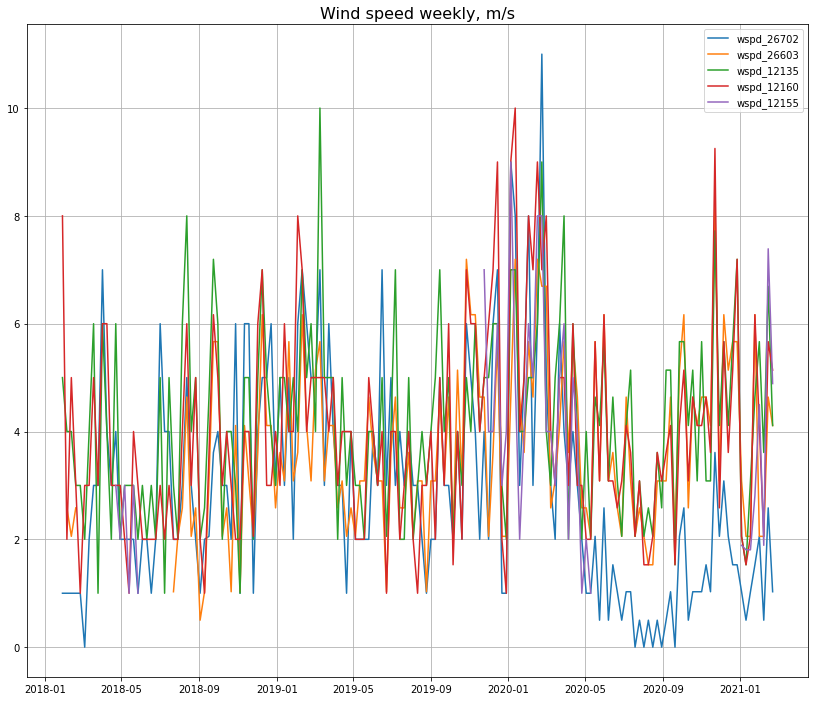

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,12))
plt.plot(wind_cond[col_list_spd][::168])
plt.legend(col_list_spd)
plt.title('Wind speed weekly, m/s', fontsize=16)
plt.grid()
plt.show()

In [32]:
# библиотека для построения розы ветров (направление, скорость ветра)
# pip install windrose

In [33]:
ws = wind_cond[col_list_spd].mean(axis=1)
wd = wind_cond[col_list_dir].mean(axis=1)
distance_to_neghb = list(round(near_['distance']))

In [34]:
from windrose import WindroseAxes
import matplotlib.cm as cm

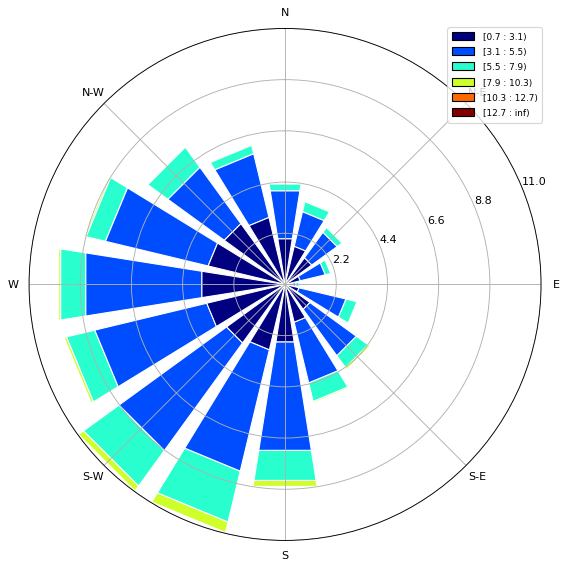

In [35]:
ax = WindroseAxes.from_ax()
ax.bar(wd, ws, normed=True, opening=0.8, edgecolor='white',)
ax.set_legend(loc='upper right')
ax.set_xticklabels(['N', 'N-E', 'E', 'S-E', 'S', 'S-W','W', 'N-W'])
ax.set_theta_zero_location('N') # по умолчанию N находится в точке E
ax.set_theta_direction(-1) # по умолчанию метки расставляются против часовой стрелки
plt.show()
# ax._info['table']

In [36]:
# import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import pylab
import windrose

C:\Users\Asus-PC12\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  


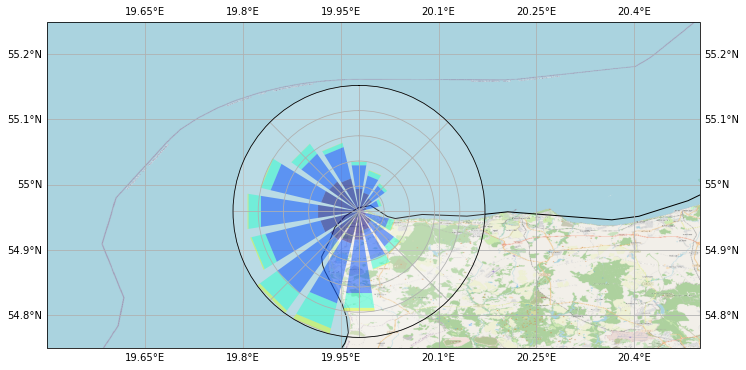

In [37]:
# coordinates of map coners to be shown
minlon, maxlon, minlat, maxlat = (19.5, 20.5, 54.75, 55.25)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(14, 6))

# Draw main ax on top of which we will add windroses
main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.gridlines(draw_labels=True)
main_ax.coastlines()

request = cimgt.OSM()
main_ax.add_image(request, 12)

# Inset axe it with a fixed size
wrax_cham = inset_axes(main_ax,
        width=3.5,                             # size in inches
        height=3.5,                            # size in inches
        loc='center',                        # center bbox at given position
        bbox_to_anchor=(lon_test, lat_test), # position of the axe
        bbox_transform=main_ax.transData,    # use data coordinate (not axe coordinate)
        axes_class=windrose.WindroseAxes,    # specify the class of the axe
        )

# Inset axe with size relative to main axe
height_deg = 0.1

wrax_cham.bar(wd, ws, alpha=.5)# прозрачность розы
for ax in [wrax_cham,]: 
    ax.tick_params(labelleft=False, labelbottom=False)
ax.set_theta_zero_location('N') # по умолчанию N находится в точке E
ax.set_theta_direction(-1) # по умолчанию метки расставляются против часовой стрелки
ax.patch.set_alpha(.2) # прозрачность сетки

plt.show()

In [38]:
day_time = ws.between_time('06:00', '22:00') # день скорость
night_time = ws.between_time('22:00', '06:00') # ночь скорость
day_time_d = wd.between_time('06:00', '22:00') # день направление
night_time_d = wd.between_time('22:00', '06:00') # ночь направление

In [39]:
day_mean, day_075, day_max = round(day_time.mean(),1), round(day_time.quantile(0.75),1), round(day_time.max(),1)
night_mean, night_075, night_max = round(night_time.mean(),1), round(night_time.quantile(0.75),1), round(night_time.max(),1)
day_mean_d, day_075_d = round(day_time_d.mean(),1), round(day_time_d.quantile(0.75),1)
night_mean_d, night_075_d = round(night_time_d.mean(),1), round(night_time_d.quantile(0.75),1)

### процент времени в день, с ветром менее 2 м/с

In [40]:
print(round(day_time[day_time < 2].count().mean()/len(day_time)*100, 1), " %")

5.3  %


### процент веремени в ночь, с ветром менее 2 м/с 

In [41]:
print(round(night_time[night_time < 2].count().mean()/len(day_time)*100, 1), " %")

6.2  %


In [42]:
winter = ws[ws.index.month <=3].append(ws[ws.index.month >=10])
winter_mean, winter_075, winter_max = round(winter.mean(),1), round(winter.quantile(.75),1), round(winter.max(),1)
summer = ws.drop(index=winter.index)
summer_mean, summer_075, summer_max = round(summer.mean(),1), round(summer.quantile(.75),1), round(summer.max(),1)

In [43]:
wspd_by_month = ws.groupby(by=[ws.index.month])
m_m, m_q, m_ma = round(wspd_by_month.mean(),1), round(wspd_by_month.quantile(.75),1), round(wspd_by_month.max(),1)
mn = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
w_b_m = list(zip(m_m, m_q, m_ma))
w_b_m = pd.DataFrame(w_b_m, columns=['Avg wind', 'Q 75% wind', 'Max wind'], index=mn).T

w_b_m["Winter's half"], w_b_m["Summer's half"], w_b_m['Night'], w_b_m['Day'] \
= [winter_mean, winter_075, winter_max], [summer_mean, summer_075, summer_max],\
[night_mean, night_075, night_max], [day_mean, day_075, day_max]

w_b_m['Winter'], w_b_m['Spring'], w_b_m['Summer'], w_b_m['Autumn'] = \
round(w_b_m[['Jan', 'Feb', 'Dec']].mean(axis=1),1), \
round(w_b_m[['Mar', 'Apr', 'May']].mean(axis=1),1), \
round(w_b_m[['Jun', 'Jul', 'Aug']].mean(axis=1),1), \
round(w_b_m[['Sep', 'Oct', 'Nov']].mean(axis=1),1)

In [44]:
winter_d = wd[wd.index.month <=3].append(wd[wd.index.month >=10])
winter_mean_d, winter_075_d = round(winter_d.mean(),1), round(winter_d.quantile(.75),1)
summer_d = wd.drop(index=winter_d.index)
summer_mean_d, summer_075_d = round(summer_d.mean(),1), round(summer_d.quantile(.75),1)

In [45]:
wdir_by_month_d = wd.groupby(by=[wd.index.month])
d_m, d_q = round(wdir_by_month_d.mean(),1), round(wdir_by_month_d.quantile(.75),1)

w_b_m_d = list(zip(d_m, d_q))
w_b_m_d = pd.DataFrame(w_b_m_d, columns=['Avg Dir', 'Q 75% Dir'], index=mn).T

w_b_m_d["Winter's half"], w_b_m_d["Summer's half"], w_b_m_d['Night'], w_b_m_d['Day'] \
= [winter_mean_d, winter_075_d], [summer_mean_d, summer_075_d], [night_mean_d, night_075_d], [day_mean_d, day_075_d]

w_b_m_d['Winter'], w_b_m_d['Spring'], w_b_m_d['Summer'], w_b_m_d['Autumn'] = \
round(w_b_m_d[['Jan', 'Feb', 'Dec']].mean(axis=1),1), \
round(w_b_m_d[['Mar', 'Apr', 'May']].mean(axis=1),1), \
round(w_b_m_d[['Jun', 'Jul', 'Aug']].mean(axis=1),1), \
round(w_b_m_d[['Sep', 'Oct', 'Nov']].mean(axis=1),1)

In [46]:
wind_stat = w_b_m.append(w_b_m_d)
wind_stat['Year'] = [sp_a, sp_q, sp_m, dir_a, dir_q]

### wind statistics

In [47]:
wind_stat.iloc[:,:12]

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Avg wind,4.6,4.3,4.3,4.1,3.6,3.3,3.5,2.9,3.7,4.0,4.0,4.5
Q 75% wind,5.6,5.4,5.4,5.0,4.5,3.8,4.2,3.4,4.4,4.8,4.9,5.4
Max wind,11.2,10.7,12.6,12.0,10.4,8.7,9.2,8.5,10.1,10.4,8.9,9.2
Avg Dir,203.8,191.0,193.7,193.9,198.8,181.3,225.0,189.2,202.3,197.0,179.4,189.7
Q 75% Dir,250.0,247.6,251.4,264.8,271.3,256.3,290.0,246.5,254.6,240.3,224.0,230.5


In [48]:
wind_stat.iloc[:,12:]

,Winter's half,Summer's half,Night,Day,Winter,Spring,Summer,Autumn,Year
Avg wind,4.3,3.5,3.6,4.0,4.5,4.0,3.2,3.9,4.0
Q 75% wind,5.3,4.2,4.5,4.9,5.5,5.0,3.8,4.7,5.0
Max wind,12.7,12.0,10.3,12.7,10.4,11.7,8.8,9.8,17.0
Avg Dir,192.6,198.5,194.2,195.8,194.8,195.5,198.5,192.9,196.0
Q 75% Dir,242.4,264.0,249.2,256.0,242.7,262.5,264.3,239.6,262.0
